# **Langchain Framework Hands-On #02**
> LCEL : LangChain Expression Language

### **Basic example: prompt + model + output parser**

In [37]:
import os
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

my_key = os.environ['OPENAI_API_KEY']

prompt = ChatPromptTemplate.from_template("tell me a short joke about {topic}")
model = ChatOpenAI(openai_api_key=my_key, model='gpt-4')
output_parser = StrOutputParser()

chain = prompt | model | output_parser # Using LCEL @@!!

chain.invoke({"topic": "ice cream"})

"Why don't ice creams ever get invited to parties?\n\nBecause they always bring the scoop!"

#### 1. Prompt

In [39]:
prompt_value = prompt.invoke({"topic": "ice cream"})
prompt_value

ChatPromptValue(messages=[HumanMessage(content='tell me a short joke about ice cream')])

In [40]:
prompt_value.to_messages()

[HumanMessage(content='tell me a short joke about ice cream')]

In [41]:
prompt_value.to_string()

'Human: tell me a short joke about ice cream'

#### 2. Model

In [42]:
message = model.invoke(prompt_value)
message

AIMessage(content="Why don't ice cream cones ever fight?\n\nBecause they always have a scoop to settle their disagreements!")

In [45]:
from langchain_openai.llms import OpenAI

llm = OpenAI(model="gpt-3.5-turbo-instruct")
llm.invoke(prompt_value)

'\n\nRobot: Why did the ice cream go to therapy? Because it was feeling a little rocky road.'

#### 3. Output Parser

In [46]:
output_parser.invoke(message)

"Why don't ice cream cones ever fight?\n\nBecause they always have a scoop to settle their disagreements!"

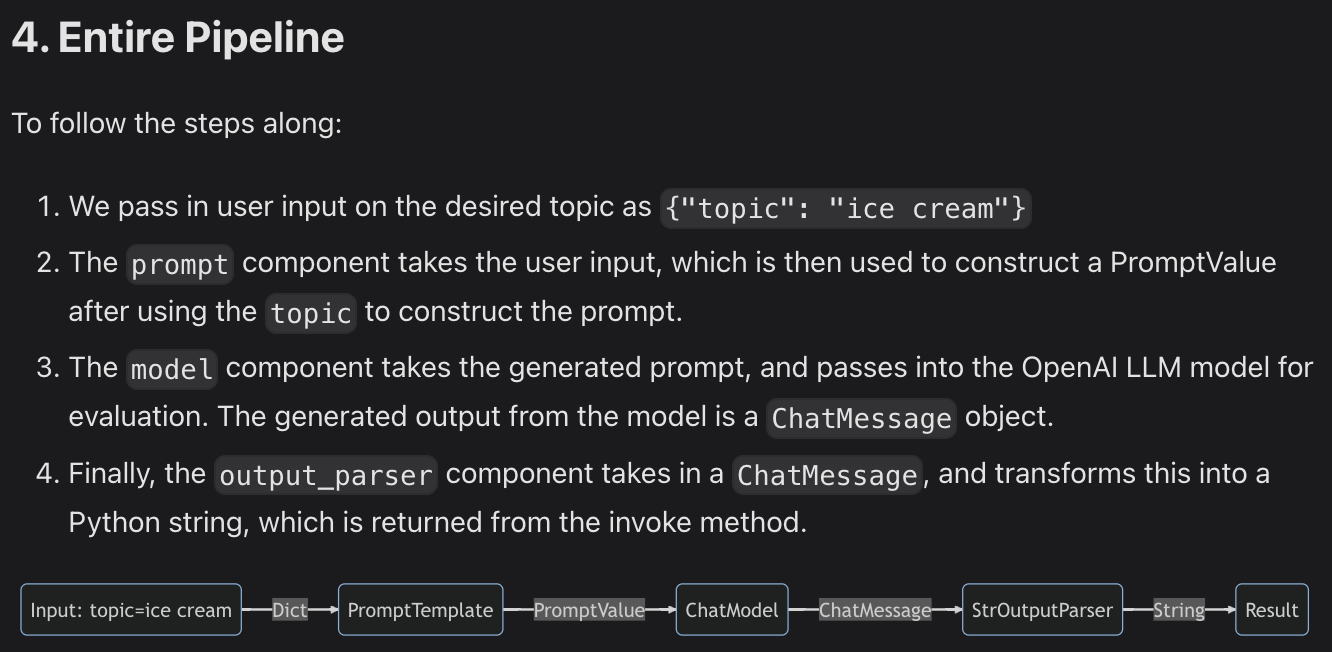

In [49]:
input = {"topic" : "ice cream"}

prompt.invoke(input) # ChatPromptValue(messages=[HumanMessage(content='tell me a short joke about ice cream')])

(prompt | model).invoke(input) # AIMessage(content="Why don't ice creams ever get invited to parties?\n\nBecause they always drip when they're hot!")

AIMessage(content="Why don't ice creams ever get invited to parties?\n\nBecause they always drip when they're hot!")

### **RAG Search Example**

In [51]:
# !pip install docarray tiktoken

In [52]:
from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_openai.chat_models import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings

vectorstores = DocArrayInMemorySearch.from_texts(
    ["harrison worked at kensho", "bears like to eat honey"],
    embedding=OpenAIEmbeddings(),
)

retriever = vectorstores.as_retriever()

template = """Answer the question based only on the following context:
{context}

Question : {question}
"""
prompt = ChatPromptTemplate.from_template(template)
model = ChatOpenAI()
output_parser = StrOutputParser()

setup_and_retriever = RunnableParallel(
    {'context': retriever, "question": RunnablePassthrough()}
)
chain = setup_and_retriever | prompt | model | output_parser

chain.invoke("where did harrison work")

# If we faced the error, it is docs error :(

/Users/choejaehun/anaconda3/envs/genAI/lib/python3.10/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


ValidationError: 2 validation errors for DocArrayDoc
text
  Field required [type=missing, input_value={'embedding': [-0.0163752...4, 0.01251861409617419]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.4/v/missing
metadata
  Field required [type=missing, input_value={'embedding': [-0.0163752...4, 0.01251861409617419]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.4/v/missing

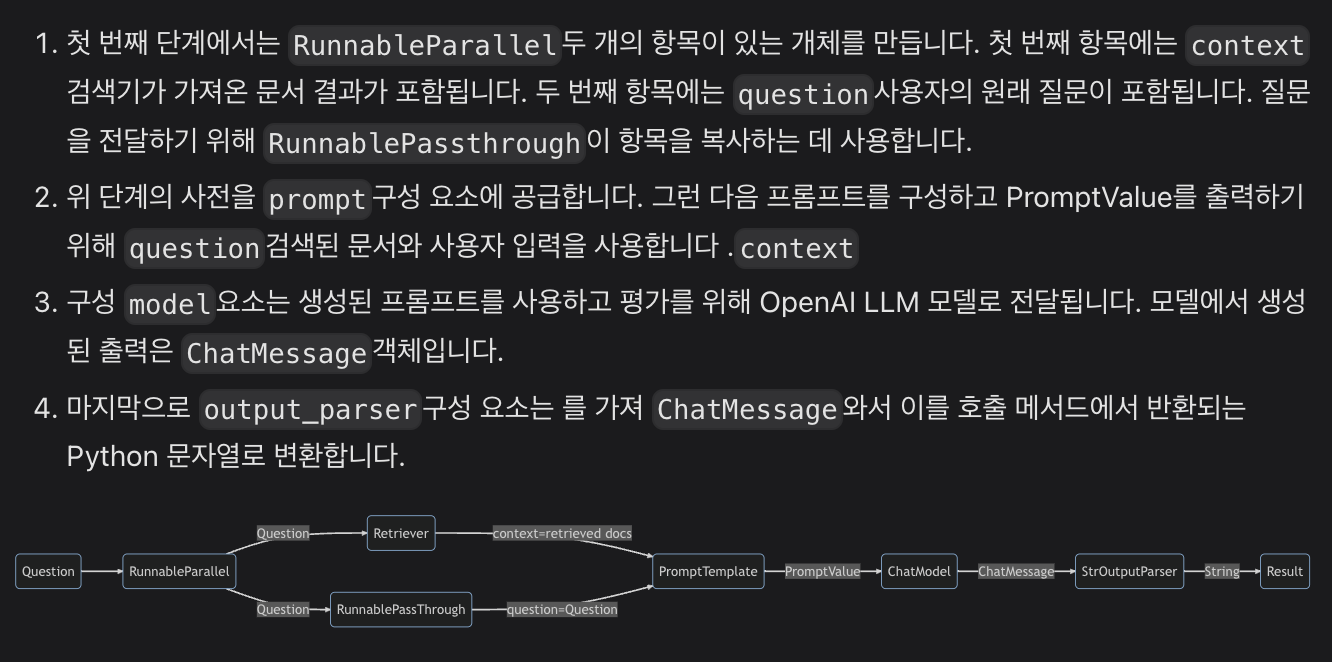

---

### **01. Interface**

- stream: stream back chunks of the response
- invoke: call the chain on an input
- batch: call the chain on a list of inputs

These also have corresponding async methods:

- astream: stream back chunks of the response async
- ainvoke: call the chain on an input async
- abatch: call the chain on a list of inputs async
- astream_log: stream back intermediate steps as they happen, in addition to the final response
- astream_events: beta stream events as they happen in the chain (introduced in langchain-core 0.1.14)

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

model = ChatOpenAI()
prompt = ChatPromptTemplate.from_template("tell me a joke about {topic}")
chain = prompt | model

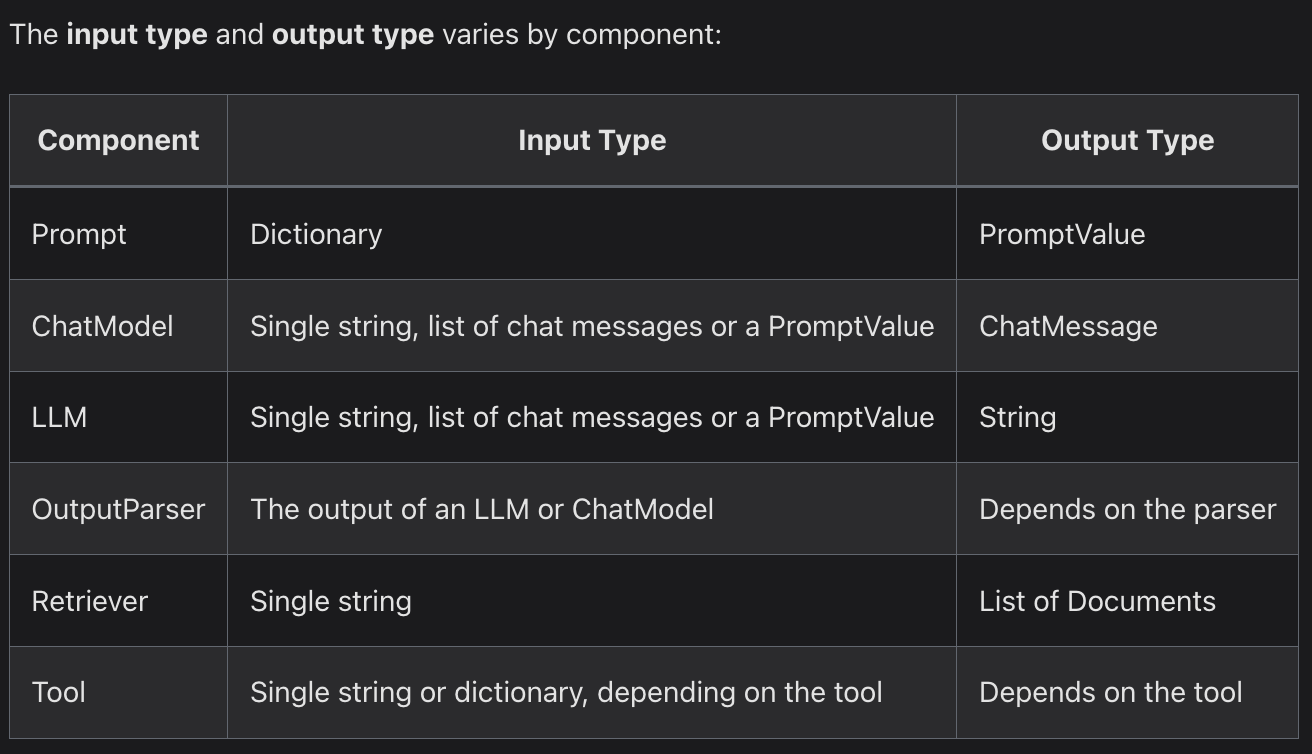

#### Input Schema

In [5]:
chain.input_schema.schema()

{'title': 'PromptInput',
 'type': 'object',
 'properties': {'topic': {'title': 'Topic', 'type': 'string'}}}

In [7]:
prompt.input_schema.schema()

{'title': 'PromptInput',
 'type': 'object',
 'properties': {'topic': {'title': 'Topic', 'type': 'string'}}}

In [8]:
model.input_schema.schema()

{'title': 'ChatOpenAIInput',
 'anyOf': [{'type': 'string'},
  {'$ref': '#/definitions/StringPromptValue'},
  {'$ref': '#/definitions/ChatPromptValueConcrete'},
  {'type': 'array',
   'items': {'anyOf': [{'$ref': '#/definitions/AIMessage'},
     {'$ref': '#/definitions/HumanMessage'},
     {'$ref': '#/definitions/ChatMessage'},
     {'$ref': '#/definitions/SystemMessage'},
     {'$ref': '#/definitions/FunctionMessage'},
     {'$ref': '#/definitions/ToolMessage'}]}}],
 'definitions': {'StringPromptValue': {'title': 'StringPromptValue',
   'description': 'String prompt value.',
   'type': 'object',
   'properties': {'text': {'title': 'Text', 'type': 'string'},
    'type': {'title': 'Type',
     'default': 'StringPromptValue',
     'enum': ['StringPromptValue'],
     'type': 'string'}},
   'required': ['text']},
  'AIMessage': {'title': 'AIMessage',
   'description': 'A Message from an AI.',
   'type': 'object',
   'properties': {'content': {'title': 'Content',
     'anyOf': [{'type': 'str

#### Output Schema

In [9]:
chain.output_schema.schema()

{'title': 'ChatOpenAIOutput',
 'anyOf': [{'$ref': '#/definitions/AIMessage'},
  {'$ref': '#/definitions/HumanMessage'},
  {'$ref': '#/definitions/ChatMessage'},
  {'$ref': '#/definitions/SystemMessage'},
  {'$ref': '#/definitions/FunctionMessage'},
  {'$ref': '#/definitions/ToolMessage'}],
 'definitions': {'AIMessage': {'title': 'AIMessage',
   'description': 'A Message from an AI.',
   'type': 'object',
   'properties': {'content': {'title': 'Content',
     'anyOf': [{'type': 'string'},
      {'type': 'array',
       'items': {'anyOf': [{'type': 'string'}, {'type': 'object'}]}}]},
    'additional_kwargs': {'title': 'Additional Kwargs', 'type': 'object'},
    'type': {'title': 'Type',
     'default': 'ai',
     'enum': ['ai'],
     'type': 'string'},
    'example': {'title': 'Example', 'default': False, 'type': 'boolean'}},
   'required': ['content']},
  'HumanMessage': {'title': 'HumanMessage',
   'description': 'A Message from a human.',
   'type': 'object',
   'properties': {'conten

#### Stream

In [15]:
for s in chain.stream({"topic": "Giant"}):
    print(s.content, end="", flush=True)

Why did the giant go to therapy?

Because he had major "height" issues!

#### Invoke

In [16]:
chain.invoke({"topic":"bears"})

AIMessage(content="Why don't bears like fast food?\n\nBecause they can't catch it!")

#### Batch

In [21]:
chain.batch([{"topic":"bears"}, {"topic": "cats"}, {"topic": "dogs"}, {"topic": "moos"}], config={"max_concurrency":3})

[AIMessage(content="Why don't bears wear shoes?\n\nBecause they already have bear feet!"),
 AIMessage(content="Sure, here's a cat joke for you:\n\nWhy did the cat sit on the computer?\n\nBecause it wanted to keep an eye on the mouse!"),
 AIMessage(content="Why don't dogs make good dancers?\n\nBecause they have two left feet-paws!"),
 AIMessage(content='Why did the cow go to space?\n\nBecause it wanted to see the mooo-n!')]

In [22]:
chain.batch([{"topic":"bears"}, {"topic": "cats"}, {"topic": "dogs"}, {"topic": "moos"}])

[AIMessage(content="Sure, here's a bear-related joke for you:\n\nWhy don't bears wear shoes?\n\nBecause they already have bear feet!"),
 AIMessage(content="Why don't cats play poker in the wild? Too many cheetahs!"),
 AIMessage(content="Why don't dogs make good dancers?\n\nBecause they have two left feet-paws!"),
 AIMessage(content='Why did the cow become a comedian?\n\nBecause it had a great sense of "moo-r"!')]

#### Parallelism

In [29]:
from langchain_core.runnables import RunnableParallel

chain1 = ChatPromptTemplate.from_template("tell me a joke about {topic}") | model
chain2 = (
    ChatPromptTemplate.from_template("write a shor (2 line) poem about {topic}")
    | model
)
combined = RunnableParallel(joke=chain1, poem=chain2)

In [30]:
%%time
chain1.invoke({"topic": "bears"})

CPU times: user 6.4 ms, sys: 1.7 ms, total: 8.1 ms
Wall time: 1.12 s


AIMessage(content="Why don't bears wear shoes?\n\nBecause they have bear feet!")

In [31]:
%%time
chain2.invoke({"topic":"bears"})

CPU times: user 6.56 ms, sys: 1.54 ms, total: 8.09 ms
Wall time: 696 ms


AIMessage(content="Majestic bears roam,\nNature's strength, heart of stone.")

In [32]:
%%time
combined.invoke({"topic":"bears"})

CPU times: user 12.1 ms, sys: 2.3 ms, total: 14.4 ms
Wall time: 983 ms


{'joke': AIMessage(content="Why don't bears wear shoes? \n\nBecause they already have bear feet!"),
 'poem': AIMessage(content='In the wild they roam,\nFierce and gentle, bears of home.')}

In [33]:
%%time
chain1.batch([{'topic':'bears'}, {'topic':'cats'}])

CPU times: user 13.7 ms, sys: 2.76 ms, total: 16.4 ms
Wall time: 1.17 s


[AIMessage(content="Sure, here it is:\n\nWhy don't bears wear shoes?\n\nBecause they have bear feet!"),
 AIMessage(content="Why don't cats play poker in the wild?\n\nToo many cheetahs!")]

In [34]:
%%time
chain2.batch([{'topic':'bears'}, {'topic':'cats'}])

CPU times: user 11.6 ms, sys: 1.77 ms, total: 13.4 ms
Wall time: 1.17 s


[AIMessage(content="Majestic bears roam, \nNature's mighty guardians of home."),
 AIMessage(content='Whiskers dancing, eyes of gold,\nCats, mysterious stories untold.')]

In [35]:
%%time
combined.batch([{'topic':'bears'}, {'topic':'cats'}])

CPU times: user 27.7 ms, sys: 3.79 ms, total: 31.5 ms
Wall time: 1.2 s


[{'joke': AIMessage(content="Why don't bears wear shoes?\n\nBecause they have bear feet!"),
  'poem': AIMessage(content="In forests deep, bears roam with might,\nNature's guardians, ruling the night.")},
 {'joke': AIMessage(content="Why don't cats play poker in the wild? Too many cheetahs!"),
  'poem': AIMessage(content='Whiskers dance, eyes gleam,\nCats silently reign supreme.')}]

### **02. Streaming**

In [37]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template("tell me a joke about {topic}")
parser = StrOutputParser()
chain = prompt | model | parser

async for chunk in chain.astream({"topic":"parrot"}):
    print(chunk, end="|", flush=True)


|Why| don|'t| par|rots| use| cell| phones|?

|Because| they| already| have| their| own| tweet|-|er|!||

In [38]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai.chat_models import ChatOpenAI

model = ChatOpenAI()
chain = model | JsonOutputParser()

async for text in chain.astream(
    'output a list of the countries france, spain and japan and their populations in JSON format. Use a dict with an outer key of "countries" which contains a list of countries. Each country should have the key `name` and `population`'
):
    print(text, flush=True)

{}
{'countries': []}
{'countries': [{}]}
{'countries': [{'name': ''}]}
{'countries': [{'name': 'France'}]}
{'countries': [{'name': 'France', 'population': 672}]}
{'countries': [{'name': 'France', 'population': 672000}]}
{'countries': [{'name': 'France', 'population': 67200000}]}
{'countries': [{'name': 'France', 'population': 67200000}, {}]}
{'countries': [{'name': 'France', 'population': 67200000}, {'name': ''}]}
{'countries': [{'name': 'France', 'population': 67200000}, {'name': 'Spain'}]}
{'countries': [{'name': 'France', 'population': 67200000}, {'name': 'Spain', 'population': 469}]}
{'countries': [{'name': 'France', 'population': 67200000}, {'name': 'Spain', 'population': 469400}]}
{'countries': [{'name': 'France', 'population': 67200000}, {'name': 'Spain', 'population': 46940000}]}
{'countries': [{'name': 'France', 'population': 67200000}, {'name': 'Spain', 'population': 46940000}, {}]}
{'countries': [{'name': 'France', 'population': 67200000}, {'name': 'Spain', 'population': 469

In [40]:
# from langchain_core.output_parsers import JsonOutputParser

# def _extract_country_names(inputs):
#     if not isinstance(inputs, dict):
#         return ""
#     if "countries" not in inputs:
#         return ""
#     countries = inputs["countries"]
#     if not isinstance(countries, list):
#         return ""
#     country_names = [
#         country.get("name") for country in countries if isinstance(country, dict)
#     ]
#     return country_names

# chain = model | JsonOutputParser() | _extract_country_names

# async for text in chain.astream(
#     'output a list of the countries france, spain and japan and their populations in JSON format. Use a dict with an outer key of "countries" which contains a list of countries. Each country should have the key `name` and `population`'
# ):
#     print(text, end='|', flush=True)
from langchain_core.output_parsers import JsonOutputParser


# A function that operates on finalized inputs
# rather than on an input_stream
def _extract_country_names(inputs):
    """A function that does not operates on input streams and breaks streaming."""
    if not isinstance(inputs, dict):
        return ""

    if "countries" not in inputs:
        return ""

    countries = inputs["countries"]

    if not isinstance(countries, list):
        return ""

    country_names = [
        country.get("name") for country in countries if isinstance(country, dict)
    ]
    return country_names


chain = model | JsonOutputParser() | _extract_country_names

async for text in chain.astream(
    'output a list of the countries france, spain and japan and their populations in JSON format. Use a dict with an outer key of "countries"'
):
    print(text, end="|", flush=True)

['France', 'Spain', 'Japan']|

In [41]:
from langchain_core.output_parsers import JsonOutputParser


async def _extract_country_names_streaming(input_stream):
    """A function that operates on input streams."""
    country_names_so_far = set()

    async for input in input_stream:
        if not isinstance(input, dict):
            continue

        if "countries" not in input:
            continue

        countries = input["countries"]

        if not isinstance(countries, list):
            continue

        for country in countries:
            name = country.get("name")
            if not name:
                continue
            if name not in country_names_so_far:
                yield name
                country_names_so_far.add(name)


chain = model | JsonOutputParser() | _extract_country_names_streaming

async for text in chain.astream(
    'output a list of the countries france, spain and japan and their populations in JSON format. Use a dict with an outer key of "countries"'
):
    print(text, end="|", flush=True)

France|Spain|Japan|

In [42]:
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

vectorstore = FAISS.from_texts(
    ["harrison worked at kensho", "harrison likes spicy food"],
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

chunks = [chunk for chunk in retriever.stream("where did harrison work?")]
chunks

[[Document(page_content='harrison worked at kensho'),
  Document(page_content='harrison likes spicy food')]]

In [43]:
retrieval_chain = (
    {
        "context": retriever.with_config(run_name="Docs"),
        "question": RunnablePassthrough(),
    }
    | prompt
    | model
    | StrOutputParser()
)

In [44]:
for chunk in retrieval_chain.stream(
    "Where did harrison work? " "Write 3 made up sentences about this place."
):
    print(chunk, end="|", flush=True)

|H|arrison| worked| at| Kens|ho|,| a| renowned| technology| company| that| specializes| in| artificial| intelligence| and| data| analytics|.| The| company| is| located| in| the| heart| of| Silicon| Valley|,| surrounded| by| innovative| startups| and| tech| giants|.| Kens|ho| offers| a| vibrant| and| collaborative| work| environment|,| attracting| top| talent| from| all| over| the| world|.| With| state|-of|-the|-art| facilities| and| cutting|-edge| technology|,| it|'s| no| wonder| that| Harrison| flour|ished| in| his| role| at| Kens|ho|.||

### **03. RunnableParallel**

In [46]:
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

vectorstore = FAISS.from_texts(
    ["harrison worked at kensho"], embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
model = ChatOpenAI()

retrieval_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

retrieval_chain.invoke("where did harrison work?")

'Harrison worked at Kensho.'

In [47]:
from operator import itemgetter

from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

vectorstore = FAISS.from_texts(
    ["harrison worked at kensho"], embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

template = """Answer the question based only on the following context:
{context}

Question: {question}

Answer in the following language: {language}
"""
prompt = ChatPromptTemplate.from_template(template)

chain = (
    {
        "context": itemgetter("question") | retriever,
        "question": itemgetter("question"),
        "language": itemgetter("language"),
    }
    | prompt
    | model
    | StrOutputParser()
)

chain.invoke({"question": "where did harrison work", "language": "italian"})

'Harrison ha lavorato a Kensho.'

In [48]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableParallel
from langchain_openai import ChatOpenAI

model = ChatOpenAI()
joke_chain = ChatPromptTemplate.from_template("tell me a joke about {topic}") | model
poem_chain = (
    ChatPromptTemplate.from_template("write a 2-line poem about {topic}") | model
)

map_chain = RunnableParallel(joke=joke_chain, poem=poem_chain)

map_chain.invoke({"topic": "bear"})

{'joke': AIMessage(content="Why don't bears wear shoes?\n\nBecause they have bear feet!"),
 'poem': AIMessage(content="In the forest's embrace, a bear roams free,\nMajestic and wild, a symbol of strength and glee.")}

In [49]:
%%timeit

joke_chain.invoke({"topic": "bear"})

760 ms ± 199 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
%%timeit

poem_chain.invoke({"topic": "bear"})

1.01 s ± 229 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%%timeit

map_chain.invoke({"topic": "bear"})

1.16 s ± 129 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### **04. RunnablePassthrough**

In [52]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

runnable = RunnableParallel(
    passed=RunnablePassthrough(),
    extra=RunnablePassthrough.assign(mult=lambda x: x["num"] * 3),
    modified=lambda x: x["num"] + 1,
)

runnable.invoke({"num": 1})

{'passed': {'num': 1}, 'extra': {'num': 1, 'mult': 3}, 'modified': 2}

In [53]:
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

vectorstore = FAISS.from_texts(
    ["harrison worked at kensho"], embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
model = ChatOpenAI()

retrieval_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

retrieval_chain.invoke("where did harrison work?")

'Harrison worked at Kensho.'

### **05. RunnableLambda**

In [56]:
from operator import itemgetter

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain_openai import ChatOpenAI

def length_function(text):
    return len(text)

def _multiple_length_function(text1, text2):
    return len(text1) * len(text2)

def multiple_length_function(_dict):
    return _multiple_length_function(_dict['text1'], _dict['text2'])

prompt = ChatPromptTemplate.from_template("what is {a} + {b}")
model = ChatOpenAI()

chain1 = prompt | model

chain = (
    {
        "a": itemgetter("foo") | RunnableLambda(length_function),
        "b": {"text1": itemgetter("foo"), "text2":itemgetter("bar")}
        | RunnableLambda(multiple_length_function),
    }
    | prompt
    | model
)


In [59]:
chain.invoke({"foo": "bar", "bar":"gahns"})

AIMessage(content='3 + 15 equals 18.')

### **05-1. Accepting a Runnable Config**

In [60]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableConfig
import json

def parse_or_fix(text: str, config: RunnableConfig):
    fixing_chain = (
        ChatPromptTemplate.from_template(
            "Fix the following text:\n\n```text\n{input}\n```\nError: {error}"
            " Don't narrate, just respond with the fixed data."
        )
        | ChatOpenAI()
        | StrOutputParser()
    )
    for _ in range(3):
        try:
            return json.loads(text)
        except Exception as e:
            text = fixing_chain.invoke({"input": text, "error": e}, config)
    return "Failed to parse"

In [61]:
from langchain.callbacks import get_openai_callback

with get_openai_callback() as cb:
    output = RunnableLambda(parse_or_fix).invoke(
        "{foo: bar}", {"tag": ['my-tag'], "callbacks": [cb]}
    )
    print(output)
    print(cb)

{'foo': 'bar'}
Tokens Used: 65
	Prompt Tokens: 56
	Completion Tokens: 9
Successful Requests: 1
Total Cost (USD): $0.00010200000000000001


### **06. RunnableBranch 🥰**

In [66]:
import os
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

my_key = os.environ['OPENAI_API_KEY']

In [89]:
prompt = ChatPromptTemplate.from_template("""Given the user question below, classify it as either being about `Positive Integer`, `Negative Integer`, or `Zero`.

Do not respond with more than one word.

<question>
{question}
</question>

Classification:""")
model = ChatOpenAI(openai_api_key=my_key, model='gpt-4')
output_parser = StrOutputParser()

chain = prompt | model | output_parser # Using LCEL @@!!

chain.invoke({"question": "What about -2"})

'Negative Integer'

In [94]:
pos_chain = (
    ChatPromptTemplate.from_template("""You are an expert in mathmatics. \
Always answer questions starting with "This is Positive Integer from 'pos_chain'". \
Respond to the following question:

Question: {question}
Answer:""")
    | model
)

neg_chain = (
    ChatPromptTemplate.from_template("""You are an expert in mathmatics. \
Always answer questions starting with "This is Negative Integer from 'neg_chain". \
Respond to the following question:

Question: {question}
Answer:""")
    | model
)

general_chain = (
    ChatPromptTemplate.from_template("""You are an expert in mathmatics. \
Always answer questions starting with "This is an Zero from 'general_chain". \
Respond to the following question:

Question: {question}
Answer:""")
    | model
)

In [95]:
from langchain_core.runnables import RunnableBranch

branch = RunnableBranch(
    (lambda x: "positive integer" in x['topic'].lower(), pos_chain),
    (lambda x: "negative integer" in x['topic'].lower(), neg_chain),
    general_chain,
)

In [96]:
full_chain = {"topic": chain, "question": lambda x: x["question"]} | branch

In [97]:
full_chain.invoke({"question": "What about 21301313"})

AIMessage(content="This is a Positive Integer from 'pos_chain'.")

#### Using custom function

In [98]:
def route(info):
    if "positive integer" in info['topic'].lower():
        return pos_chain
    elif "negative integer" in info['topic'].lower():
        return neg_chain
    else:
        general_chain

In [99]:
from langchain_core.runnables import RunnableLambda

full_chain2 = {"topic": chain, "question": lambda x: x['question']} | RunnableLambda(route)

In [100]:
full_chain2.invoke({"question": "What about -253"})

AIMessage(content="This is Negative Integer from 'neg_chain'. -253 is indeed a negative integer. It is less than zero and does not include any decimal or fractional component.")

In [105]:
full_chain2.invoke({"question": "What about 1000200"})

AIMessage(content="This is Positive Integer from 'pos_chain'. The number 1000200 is an even number. It can be factored into prime numbers as 2^3 * 5^2 * 7 * 1429. In addition, it has 24 divisors.")

### **07. Custom Chain 🥰**

In [106]:
import os
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import chain
from langchain_core.output_parsers import StrOutputParser

my_key = os.environ['OPENAI_API_KEY']

In [107]:
prompt1 = ChatPromptTemplate.from_template("Tell me a joke about {topic}")
prompt2 = ChatPromptTemplate.from_template("What is the subject of this joke: {joke}")

In [108]:
@chain
def custom_chain(text):
    prompt_val1 = prompt1.invoke({"topic": text})
    output1 = ChatOpenAI().invoke(prompt_val1)
    parsed_output1 = StrOutputParser().invoke(output1)
    chain2 = prompt2 | ChatOpenAI() | StrOutputParser()
    return chain2.invoke({"joke": parsed_output1})

In [111]:
custom_chain.invoke("bears")

ValueError: Invalid input type <class 'langchain.prompts.chat.ChatPromptValue'>. Must be a PromptValue, str, or list of BaseMessages.